# SWOT Cycle 16 Global Mosaic

Takes all SWOT L3 swath passes from Cycle 16 into a global mosaic.
From AVISO L3 Basic, SWOT L3_LR_SSH_BASIC https://www.aviso.altimetry.fr/en/data/products/sea-surface-height-products/global/swot-l3-ocean-products.html


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
from glob import glob
import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
data_dir = Path('swot_l3_cycle016')
nc_files = sorted(glob(str(data_dir / '*.nc')))
print(f"Found {len(nc_files)} files")

Found 567 files


In [3]:
sample_ds = xr.open_dataset(nc_files[0])
print(sample_ds)

<xarray.Dataset> Size: 27MB
Dimensions:          (num_lines: 9860, num_pixels: 69, num_nadir: 1421)
Coordinates:
    latitude         (num_lines, num_pixels) float64 5MB ...
    longitude        (num_lines, num_pixels) float64 5MB ...
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables:
    time             (num_lines) datetime64[ns] 79kB ...
    mdt              (num_lines, num_pixels) float64 5MB ...
    ssha_filtered    (num_lines, num_pixels) float64 5MB ...
    ssha_unfiltered  (num_lines, num_pixels) float64 5MB ...
    i_num_line       (num_nadir) int16 3kB ...
    i_num_pixel      (num_nadir) int8 1kB ...
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0/PIC0/PIC2 (NAS...
    doi:         

## Grid the swath data

In [4]:
def create_global_grid(resolution=0.1):
    lon_grid = np.arange(-180, 180 + resolution, resolution)
    lat_grid = np.arange(-90, 90 + resolution, resolution)
    return lon_grid, lat_grid

lon_grid, lat_grid = create_global_grid(resolution=0.1)
print(f"Grid: {len(lon_grid)} x {len(lat_grid)}")

Grid: 3601 x 1801


In [5]:
def grid_swath_data(nc_files, lon_grid, lat_grid, variable='ssha_karin'):
    gridded_sum = np.zeros((len(lat_grid), len(lon_grid)))
    gridded_count = np.zeros((len(lat_grid), len(lon_grid)))
    
    dlon = lon_grid[1] - lon_grid[0]
    dlat = lat_grid[1] - lat_grid[0]
    
    for i, nc_file in enumerate(nc_files):
        if (i + 1) % 50 == 0:
            print(f"{i + 1}/{len(nc_files)}")
        
        try:
            ds = xr.open_dataset(nc_file)
            
            if 'latitude' in ds.coords:
                lats = ds['latitude'].values
                lons = ds['longitude'].values
            elif 'lat' in ds.coords:
                lats = ds['lat'].values
                lons = ds['lon'].values
            else:
                lat_vars = [v for v in ds.variables if 'lat' in v.lower()]
                lon_vars = [v for v in ds.variables if 'lon' in v.lower()]
                if lat_vars and lon_vars:
                    lats = ds[lat_vars[0]].values
                    lons = ds[lon_vars[0]].values
                else:
                    ds.close()
                    continue
            
            if variable in ds.variables:
                data = ds[variable].values
            else:
                ssh_vars = [v for v in ds.variables if 'ssh' in v.lower() or 'sla' in v.lower()]
                if ssh_vars:
                    data = ds[ssh_vars[0]].values
                    if i == 0:
                        print(f"Using {ssh_vars[0]}")
                else:
                    ds.close()
                    continue
            
            if lats.ndim > 1:
                lats = lats.flatten()
                lons = lons.flatten()
                data = data.flatten()
            
            valid_mask = (~np.isnan(data)) & (np.abs(data) < 10) & (lats >= -90) & (lats <= 90)
            
            if valid_mask.sum() == 0:
                ds.close()
                continue
            
            lats_valid = lats[valid_mask]
            lons_valid = lons[valid_mask]
            data_valid = data[valid_mask]
            
            lons_valid = np.where(lons_valid > 180, lons_valid - 360, lons_valid)
            
            lon_idx = np.floor((lons_valid - lon_grid[0]) / dlon).astype(int)
            lat_idx = np.floor((lats_valid - lat_grid[0]) / dlat).astype(int)
            
            valid_idx = (lon_idx >= 0) & (lon_idx < len(lon_grid)) & (lat_idx >= 0) & (lat_idx < len(lat_grid))
            
            lon_idx = lon_idx[valid_idx]
            lat_idx = lat_idx[valid_idx]
            data_valid = data_valid[valid_idx]
            
            for j in range(len(data_valid)):
                gridded_sum[lat_idx[j], lon_idx[j]] += data_valid[j]
                gridded_count[lat_idx[j], lon_idx[j]] += 1
            
            ds.close()
            
        except Exception as e:
            continue
    
    gridded_mean = np.full_like(gridded_sum, np.nan)
    mask = gridded_count > 0
    gridded_mean[mask] = gridded_sum[mask] / gridded_count[mask]
    
    print(f"\nCoverage: {100 * mask.sum() / (len(lat_grid) * len(lon_grid)):.1f}%")
    
    return gridded_mean, gridded_count

ssh_mosaic, observation_count = grid_swath_data(nc_files, lon_grid, lat_grid)

Using ssha_filtered
50/567
100/567
150/567
200/567
250/567
300/567
350/567
400/567
450/567
500/567
550/567

Coverage: 54.6%


## Global mosaic

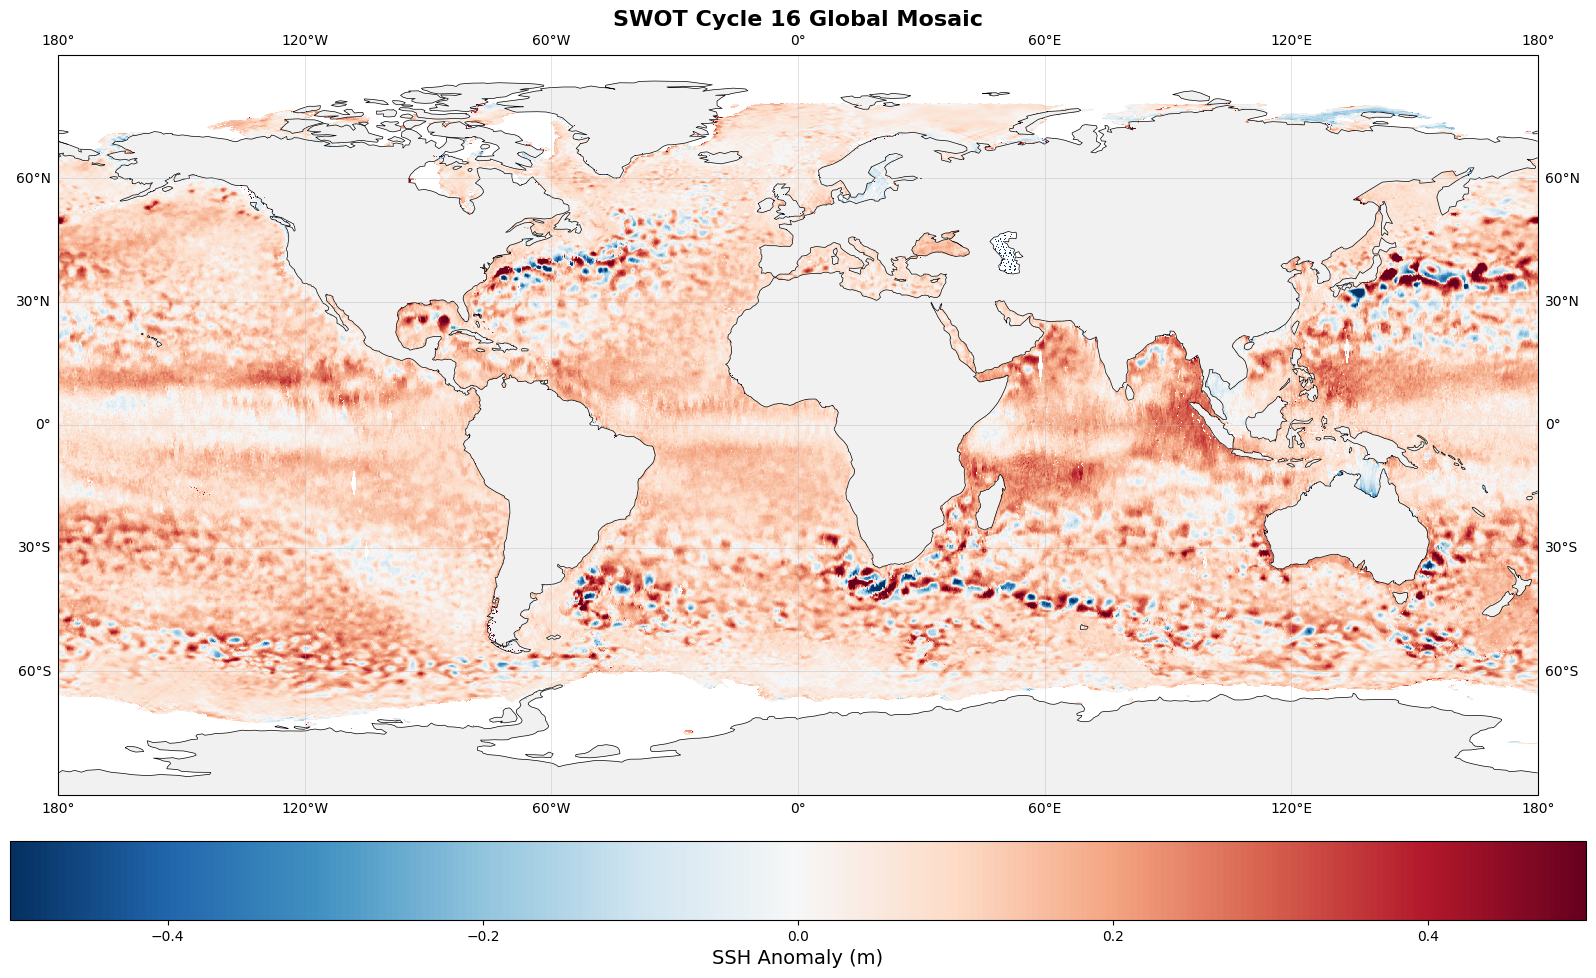

In [10]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
im = ax.pcolormesh(lon_mesh, lat_mesh, ssh_mosaic, 
                   transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', 
                   vmin=-0.5, vmax=0.5,
                   shading='auto')

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)

cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('SSH Anomaly (m)', fontsize=14)

ax.set_title('SWOT Cycle 16 Global Mosaic', fontsize=16, weight='bold')

plt.tight_layout()
plt.show()


## Save to NetCDF

In [8]:
mosaic_ds = xr.Dataset(
    {
        'ssha': (['lat', 'lon'], ssh_mosaic),
        'observation_count': (['lat', 'lon'], observation_count)
    },
    coords={
        'lon': lon_grid,
        'lat': lat_grid
    },
    attrs={
        'title': 'SWOT Cycle 16 Global Mosaic',
        'description': 'Gridded SSH anomaly from SWOT L3 swath data',
        'source': 'AVISO SWOT L3 Basic',
        'cycle': 16,
        'grid_resolution': '0.1 degrees',
        'creation_date': str(np.datetime64('today'))
    }
)

mosaic_ds['ssha'].attrs = {
    'long_name': 'Sea Surface Height Anomaly',
    'units': 'meters'
}

mosaic_ds['observation_count'].attrs = {
    'long_name': 'Observation Count',
    'units': 'count'
}

output_file = 'swot_cycle16_global_mosaic.nc'
mosaic_ds.to_netcdf(output_file)
print(f"Saved to {output_file} ({Path(output_file).stat().st_size / 1024**2:.1f} MB)")

Saved to swot_cycle16_global_mosaic.nc (99.0 MB)


## Regional zoom (North Atlantic)

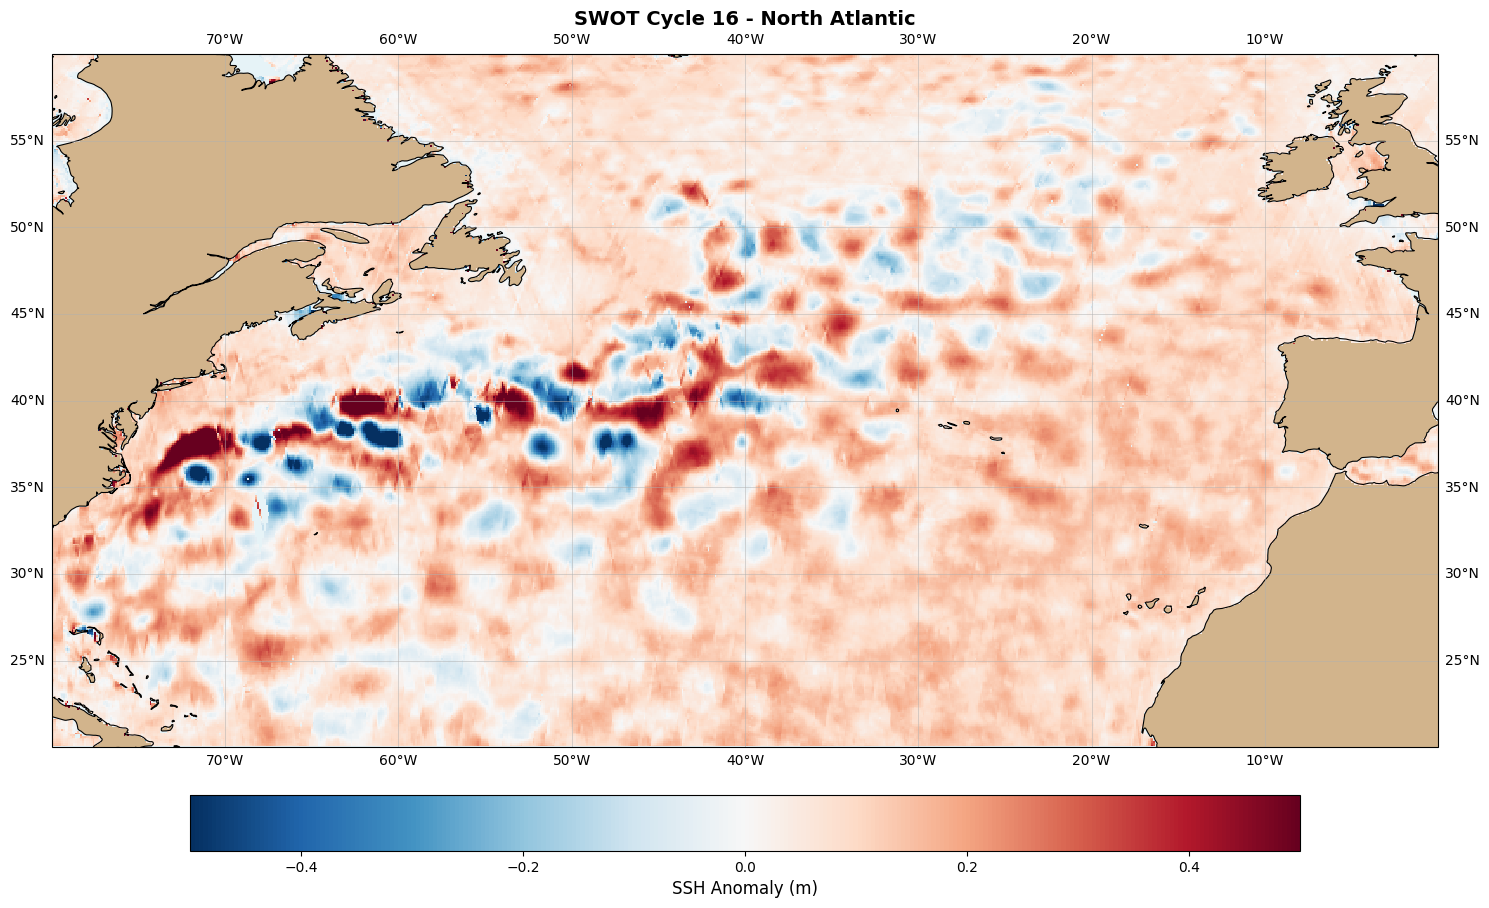

In [9]:
lon_min, lon_max = -80, 0
lat_min, lat_max = 20, 60

lon_mask = (lon_grid >= lon_min) & (lon_grid <= lon_max)
lat_mask = (lat_grid >= lat_min) & (lat_grid <= lat_max)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

regional_ssh = ssh_mosaic[np.ix_(lat_mask, lon_mask)]
regional_lon = lon_grid[lon_mask]
regional_lat = lat_grid[lat_mask]
lon_mesh_reg, lat_mesh_reg = np.meshgrid(regional_lon, regional_lat)

im = ax.pcolormesh(lon_mesh_reg, lat_mesh_reg, regional_ssh,
                   transform=ccrs.PlateCarree(),
                   cmap='RdBu_r',
                   vmin=-0.5, vmax=0.5,
                   shading='auto')

ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='tan')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.7)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('SSH Anomaly (m)', fontsize=12)

ax.set_title('SWOT Cycle 16 - North Atlantic', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()